<a href="https://colab.research.google.com/github/Arjunar92/Hands-On-ML-with-SckitLearn-Keras-TensorFlow/blob/main/02_California_Housing_Price_Prediction_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 2 - End-to End Machine Learning Project**

This notebook contains all codes to Predict median housing prices in California.

In [1]:
#This project we will be using Python 3.7 or above

import sys

assert sys.version_info >= (3, 7)

In [2]:
#It also requires Scikit-Learn ≥ 1.0.1:

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
# Functions to Fetch and load data into a pandas Dataframe

from pathlib import Path
import pandas as pd
import tarfile as tf
import urllib.request

def load_housing_data():

  #Search if file is in directory, if not then search the file from Ageron's gothub repo
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tf.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")
  return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [4]:
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [7]:
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

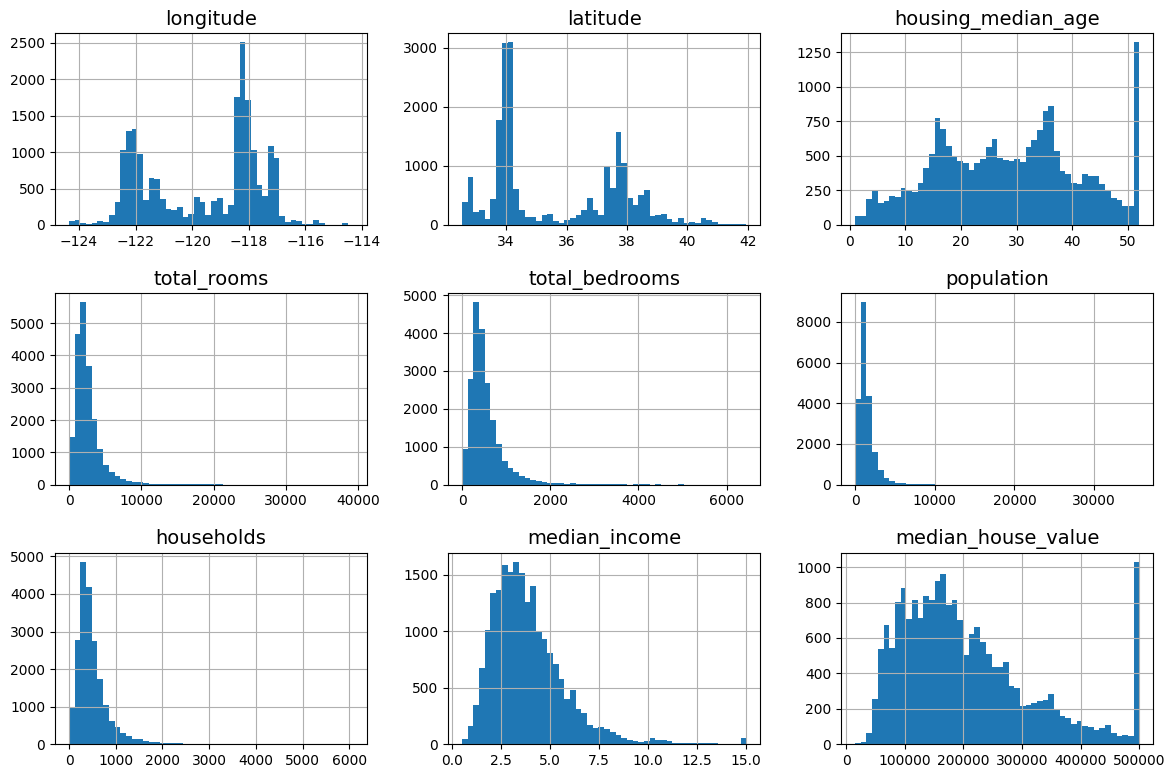

In [8]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins = 50, figsize =(12,8))
save_fig("attribute_histogram_plots")
plt.show()

# **Create a Test set**

We create test set in the begining to avoid data overfitting.

*Data snooping bias*

Typically set 20% of data and set them aside.

In [9]:
# Create test set and set aside
import numpy as np


#Method 1:
def shuffle_and_split_data(data, test_ratio):
    np.random.seed(42) #So that you get consistant indices for train and test set each time we run the code.
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

To ensure that this notebook's outputs remain the same every time we run it, we need to set the random seed:

Sadly, this won't guarantee that this notebook will output exactly the same results as in the book, since there are other possible sources of variation. The most important is the fact that algorithms get tweaked over time when libraries evolve. So please tolerate some minor differences: hopefully, most of the outputs should be the same, or at least in the right ballpark.

Note: another source of randomness is the order of Python sets: it is based on Python's hash() function, which is randomly "salted" when Python starts up (this started in Python 3.3, to prevent some denial-of-service attacks). To remove this randomness, the solution is to set the PYTHONHASHSEED environment variable to "0" before Python even starts up. Nothing will happen if you do it after that. Luckily, if you're running this notebook on Colab, the variable is already set for you.

In [10]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Since the housing data does not have an ID column.

You can use row index as ID.


In [11]:
housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")
test_set.head(4)

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY
16,16,-122.27,37.85,52.0,1966.0,347.0,793.0,331.0,2.7750,152500.0,NEAR BAY


OR generate your own unique ID, maybe use the latitude and longitude details

In [12]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")
test_set.head(4)


,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19


Instead of using the above functions. You can also use Sklean's function the split traintest data.

In [13]:
#Scikit-Leans function to split train test data

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set.head(4)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-122.38,40.67,10.0,2281.0,444.0,1274.0,438.0,2.2120,65600.0,INLAND
3024,-118.37,33.83,35.0,1207.0,207.0,601.0,213.0,4.7308,353400.0,<1H OCEAN
15663,-117.24,32.72,39.0,3089.0,431.0,1175.0,432.0,7.5925,466700.0,NEAR OCEAN
20484,-118.44,34.05,18.0,4780.0,1192.0,1886.0,1036.0,4.4674,500001.0,<1H OCEAN


The above code is when the same is picked randomly. In case if we want a startified sample. DO the following.

In this specific project, We are told by the management that median income plays an important role to decide the median housing price. Thus we need to startify based on median income.

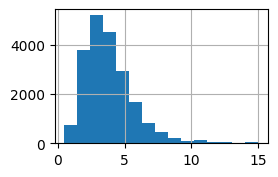

In [14]:
housing["median_income"].hist(bins= 15, figsize=(3,2))
save_fig("median_income_histogram")
plt.show()

In [15]:
#Create income category variable with 5 categories.
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

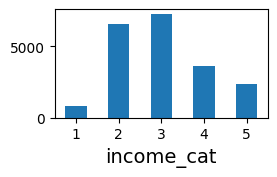

In [16]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, figsize=(3,2))
save_fig("income_cat_bar_plot")
plt.show()

Now we are ready to do stratified sampling based on income category.

We can use Scikit-Learn model_selection package to split the dataset. This uses a split() method to craete many such splits.

We cteate multiple splits so that we can perform cross validation in future.

In [17]:
#Code for stratified sampling with multiple splits

from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append((strat_train_set_n, strat_test_set_n))

In [18]:
#Just using the first split for now
strat_train_set, strat_test_set = strat_splits[0]

strat_test_set.head(4)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,<1H OCEAN,5
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,202900.0,<1H OCEAN,4
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,310000.0,NEAR OCEAN,3
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,314300.0,NEAR OCEAN,3


OR you can use an simpler function in case you just want one split.

In [19]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)
strat_test_set.head

<bound method NDFrame.head of        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
3905     -121.95     37.11                21.0       2387.0           357.0   
16821    -118.01     33.89                36.0       1589.0           265.0   
2900     -118.18     33.74                30.0       5915.0          1750.0   
7193     -122.48     37.74                52.0       2166.0           423.0   
13928    -122.39     37.78                 5.0       1405.0           515.0   
...          ...       ...                 ...          ...             ...   
12369    -124.16     40.79                46.0       3042.0           597.0   
8707     -119.01     35.39                29.0       1820.0           459.0   
16634    -123.01     38.67                33.0        914.0           147.0   
9779     -122.03     37.60                24.0       2077.0           383.0   
3455     -117.12     32.74                52.0       1969.0           389.0   

       population  households  median_income  median_house_value  \
3905        913.0       341.0         7.7360            397700.0   
16821       804.0       272.0         4.6354            202900.0   
2900       2136.0      1503.0         4.0968            310000.0   
7193       1072.0       370.0         4.1310            314300.0   
13928       725.0       392.0         3.6037            187500.0   
...           ...         ...            ...                 ...   
12369      1206.0       541.0         2.1135             90600.0   
8707       1134.0       419.0         1.8289             59400.0   
16634       394.0       132.0         4.6875            246200.0   
9779       1488.0       389.0         4.5721            214700.0   
3455        877.0       424.0         3.7900            163400.0   

      ocean_proximity income_cat  
3905        <1H OCEAN          5  
16821       <1H OCEAN          4  
2900       NEAR OCEAN          3  
7193       NEAR OCEAN          3  
13928        NEAR BAY          3  
...               ...        ...  
12369      NEAR OCEAN          2  
8707           INLAND          2  
16634       <1H OCEAN          4  
9779         NEAR BAY          4  
3455       NEAR OCEAN          3  

[4128 rows x 11 columns]>

In [20]:
#To compare the income categories propotion in Random, Strattified and whole data
def income_cat_propotions(data):

  return (data['income_cat'].value_counts()*100 / len(data)).round(2)


test_set, train_set = train_test_split(housing, test_size=0.2, random_state=42)



compare_data = pd.DataFrame({

                             "Overall %": income_cat_propotions(housing),
                             "Random %": income_cat_propotions(test_set),
                             "Stratified %": income_cat_propotions(strat_test_set)
}).sort_index()
compare_data.index.name = "Income Category"
compare_data["Rand Error %"] = (compare_data["Random %"] /
                                  compare_data["Overall %"] - 1)
compare_data["Strat Error %"] = (compare_data["Stratified %"] /
                                   compare_data["Overall %"] - 1)
compare_data

,Overall %,Random %,Stratified %,Rand Error %,Strat Error %
Income Category,,,,,
1,3.98,3.92,4.00,-0.015075,0.005025
2,31.88,32.17,31.88,0.009097,0.000000
3,35.06,35.19,35.05,0.003708,-0.000285
4,17.63,17.44,17.64,-0.010777,0.000567
5,11.44,11.28,11.43,-0.013986,-0.000874


In [21]:
#Drop the income_cat column
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

In [22]:
strat_train_set.head(4)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND


# Discover and Visualize the Data to Gain Insights

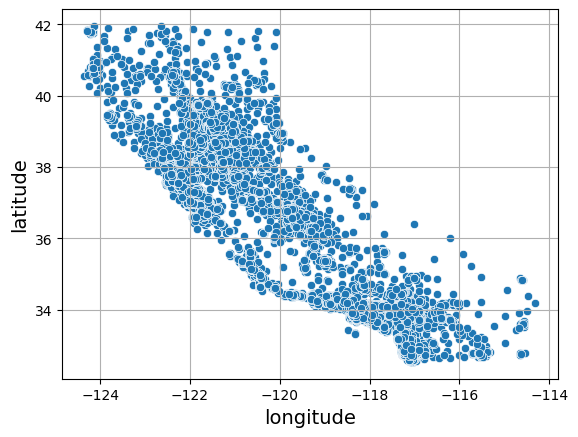

In [23]:
import seaborn as sns

sns.scatterplot(data=housing, x="longitude", y="latitude")
plt.grid(True)


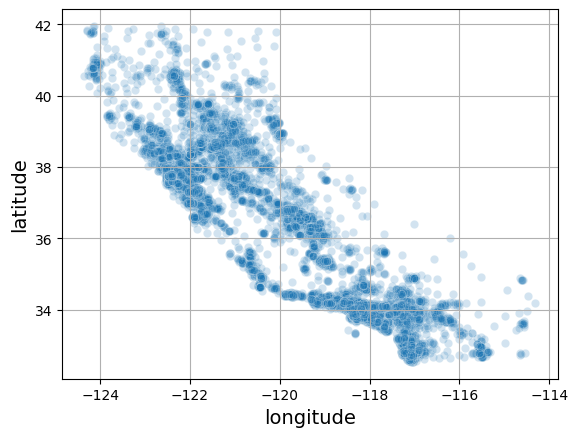

In [24]:
import seaborn as sns

sns.scatterplot(data=housing, x="longitude", y="latitude", alpha =0.2)
plt.grid(True)

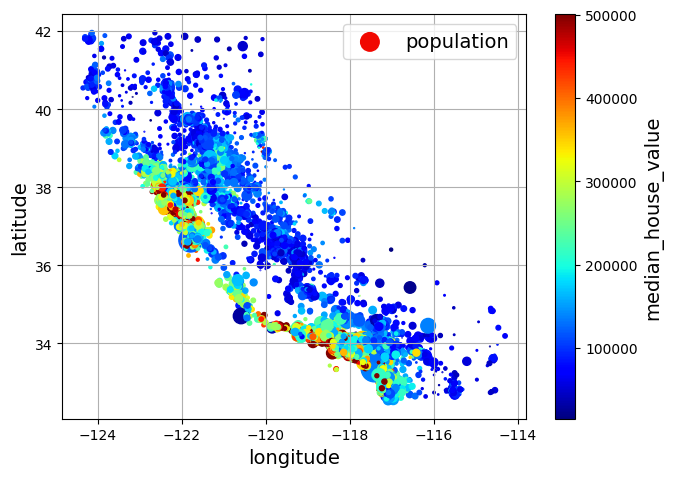

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(7, 5))
save_fig("housing_prices_scatterplot")  # extra code
plt.show()

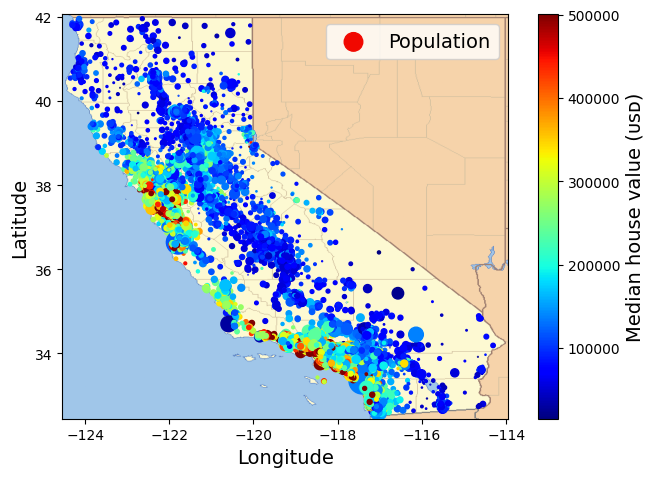

In [28]:

# Download the California image
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(7, 5))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

# Looking for Correlations

In [32]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [33]:
corr_matrix['median_house_value'].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688075
total_rooms,0.134153
housing_median_age,0.105623
households,0.065843
total_bedrooms,0.049686
population,-0.024650
longitude,-0.045967
latitude,-0.144160


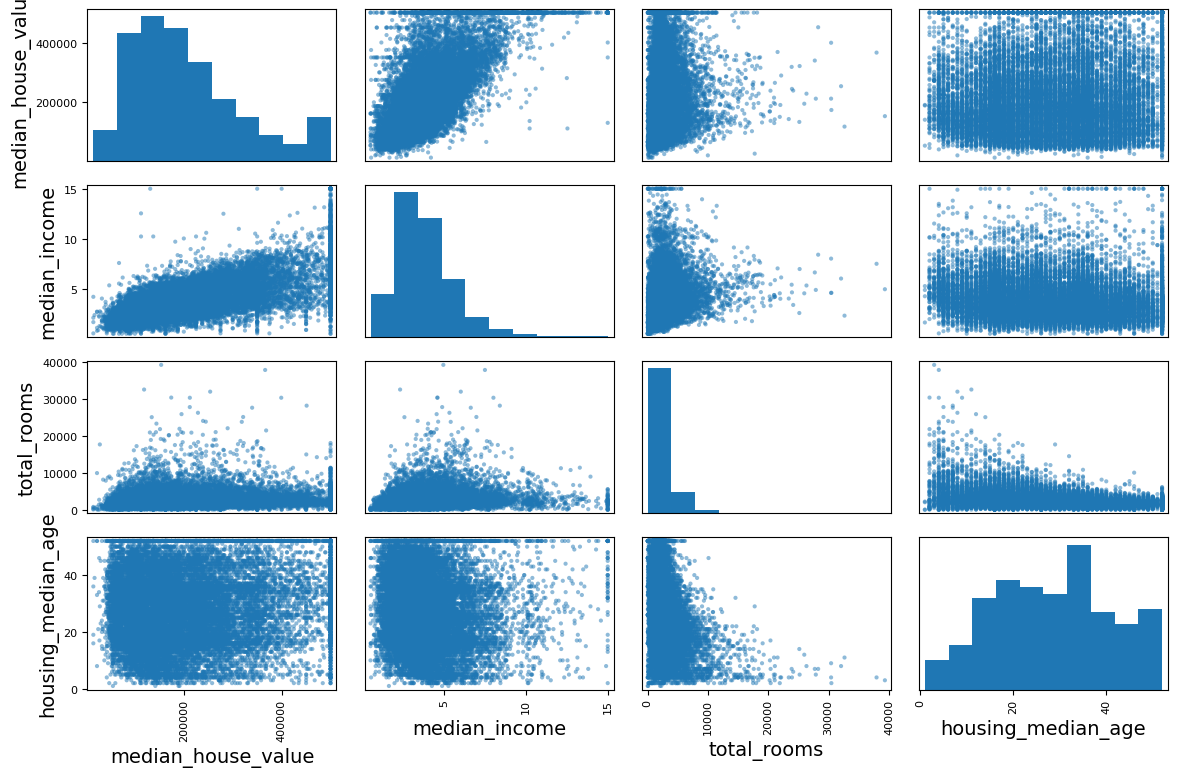

In [35]:
#Visualize Correlation
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()